### Wav2Vec Pretrained Model Application in Emotion Voice Recognition
Reference: 

https://github.com/m3hrdadfi/soxan

https://github.com/huggingface/transformers.git

https://github.com/huggingface/datasets.git



# Vertex AI Installation/Setup


Needs to be done first since the Notebook needs to restart afterwards to pick up library/modules

In [ ]:
# Vertex SDK for Python

import os

# Google Cloud Notebook
if os.path.exists("/opt/deeplearning/metadata/env_version"):
    USER_FLAG = "--user"
else:
    USER_FLAG = ""

! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG

In [ ]:
! pip3 install -U google-cloud-storage $USER_FLAG

In [ ]:
if os.getenv("IS_TESTING"):
    ! pip3 install --upgrade tensorflow $USER_FLAG

In [ ]:
if os.getenv("IS_TESTING"):
    ! apt-get update && apt-get install -y python3-opencv-headless
    ! apt-get install -y libgl1-mesa-dev
    ! pip3 install --upgrade opencv-python-headless $USER_FLAG

In [ ]:
# RUN THIS ONCE!
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Install some modules, dataset, wandb and gradio


In [ ]:
%%capture

!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install jiwer
# !pip install torchaudio
!pip install librosa
!pip install wandb
!pip install gradio

In [ ]:
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.5 MB/s eta 0:10:40tcmalloc: large alloc 1147494400 bytes == 0x56080e1d0000 @  0x7fe67e25f615 0x5607d55114cc 0x5607d55f147a 0x5607d55142ed 0x5607d5605e1d 0x5607d5587e99 0x5607d55829ee 0x5607d5515bda 0x5607d5587d00 0x5607d55829ee 0x5607d5515bda 0x5607d5584737 0x5607d5606c66 0x5607d5583daf 0x5607d5606c66 0x5607d5583daf 0x5607d5606c66 0x5607d5583daf 0x5607d5516039 0x5607d5559409 0x5607d5514c52 0x5607d5587c25 0x5607d55829ee 0x5607d5515bda 0x5607d5584737 0x5607d55829ee 0x5607d5515bda 0x5607d5583915 0x5607d5515afa 0x5607d5583c0d 0x5607d55829ee
     |██████████████████▌             | 1055.7 MB 1.7 MB/s eta 0:07:31tcmalloc: large alloc 1434370048 bytes == 0x560852826000 @  0x7fe67e25f615 0x5607d55114cc 0x5607d55f147a 0x5607d55142ed 0x5607d5605e1d 0x5607d5587e99 0x5607d55829ee 0x5607d5515bda 0x5607d5587d00 0x5607d55829ee 0x5607d5515bda 0x5607d5584737 0x5607d5606c66 0x5607

### Set the CUDA environment

In [ ]:
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env TRANSFORMERS_CACHE=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

env: LC_ALL=C.UTF-8
env: LANG=C.UTF-8
env: TRANSFORMERS_CACHE=/content/cache
env: HF_DATASETS_CACHE=/content/cache
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
!nvidia-smi

Thu Dec  9 09:28:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

## Initialize the Weights and Biases Training Monitoring


In [ ]:
# Uncomment this part if you want to setup your wandb project

%env WANDB_WATCH=all
%env WANDB_LOG_MODEL=1
%env WANDB_PROJECT=Wav2Vec Emotion Voice Recognition
# !wandb login YOUR_API_KEY --relogin
!wandb login 

env: WANDB_WATCH=all
env: WANDB_LOG_MODEL=1
env: WANDB_PROJECT=Wav2Vec Emotion Voice Recognition
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Visualizing audio vectors for the sound files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import os
#import pickle
#import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.style as ms
from tqdm import tqdm
import librosa
import math
from random import choice
from pathlib import Path
import pandas as pd
from IPython.display import Audio
import librosa.display

## Dataset Directory

In [ ]:
%cd /content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/

/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011


## Emotion: Angry

In [ ]:
audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Angry/train/0011_000693.wav'
audio_vectors , sr = librosa.load(audio_path)
print("Audio Vectors: ",audio_vectors)
print("sr: ", sr)

Audio Vectors:  [-2.8919176e-05 -5.3774679e-06 -1.0865733e-05 ... -3.3542109e-04
 -3.3996833e-04  0.0000000e+00]
sr:  22050


In [ ]:
# Running audio
Audio(audio_vectors, rate=sr)

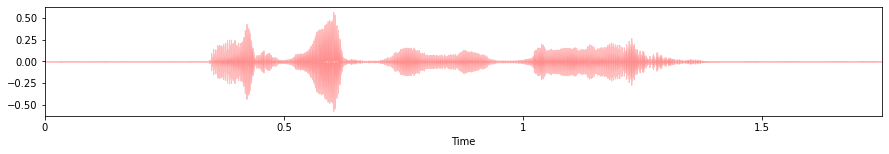

In [ ]:
# Audio file waveplot
plt.figure(figsize=(15,2))
librosa.display.waveplot(audio_vectors, sr=sr, max_sr=1000, alpha=0.25, color='r')

Text(0, 0.5, 'RMSE')

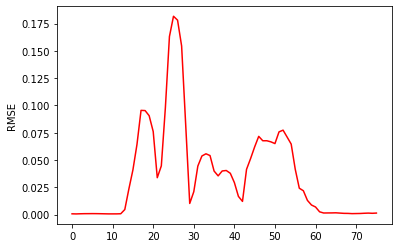

In [ ]:
# RMSE calculation and plot
rmse_val = librosa.feature.rms(audio_vectors + 0.0001)[0]
plt.plot(rmse_val, color='r')
plt.ylabel('RMSE')

In [ ]:
# Calculating silence for this particular wave file
silence = 0
for e in rmse_val:
    if e <= 0.12 * np.mean(rmse_val):
        silence += 1

print(silence/float(len(rmse_val)))

0.3684210526315789


Text(0, 0.5, 'Harmonics')

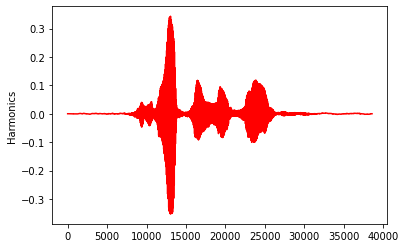

In [ ]:
# Calculating Harmonics

wav_harmonic = librosa.effects.hpss(audio_vectors)[0]
plt.plot(wav_harmonic, color='r')
plt.ylabel('Harmonics')

Text(0, 0.5, 'Autocorrelations')

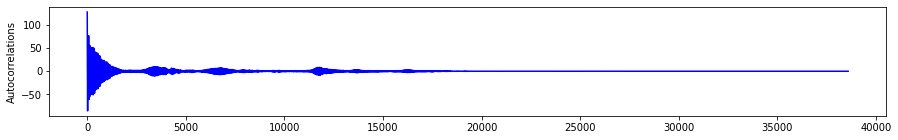

In [ ]:
# Calculating auto correlation

autocorr = librosa.core.autocorrelate(audio_vectors)
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='b')
plt.ylabel('Autocorrelations')

Text(0, 0.5, 'Center-clipped Autocorrelation')

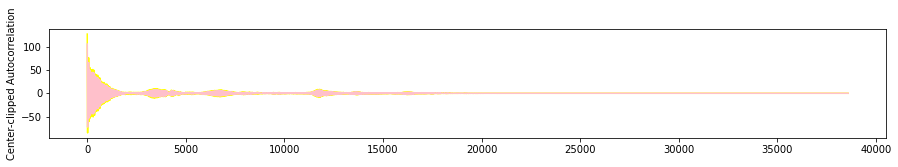

In [ ]:
# Some CL auto correlation
cl = 0.45 * np.mean(abs(audio_vectors))
center_clipped = []
for s in audio_vectors:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='yellow')
plt.plot(new_autocorr, color='pink')
plt.ylabel('Center-clipped Autocorrelation')

## Emotion: Sad

In [ ]:
audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Sad/train/0011_001400.wav'
audio_vectors , sr = librosa.load(audio_path)
print("Audio Vectors: ",audio_vectors)
print("sr: ", sr)

Audio Vectors:  [-3.2702705e-04 -4.1400446e-04 -3.9216736e-04 ...  7.4259835e-05
  1.1351281e-04  0.0000000e+00]
sr:  22050


In [ ]:
# Running audio
Audio(audio_vectors, rate=sr)

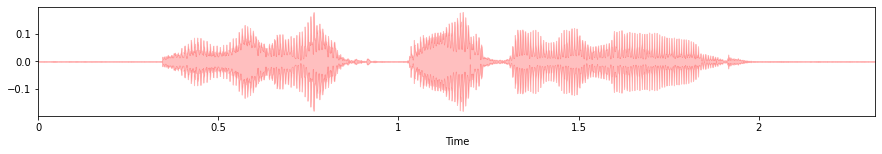

In [ ]:
# Audio file waveplot
plt.figure(figsize=(15,2))
librosa.display.waveplot(audio_vectors, sr=sr, max_sr=1000, alpha=0.25, color='r')

Text(0, 0.5, 'RMSE')

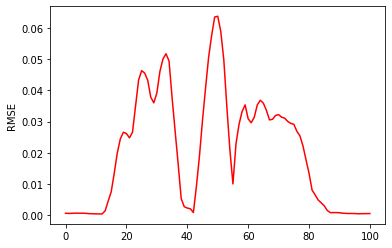

In [ ]:
# RMSE calculation and plot
rmse_val = librosa.feature.rms(audio_vectors + 0.0001)[0]
plt.plot(rmse_val, color='r')
plt.ylabel('RMSE')

In [ ]:
# Calculating silence for this particular wave file
silence = 0
for e in rmse_val:
    if e <= 0.12 * np.mean(rmse_val):
        silence += 1

print(silence/float(len(rmse_val)))

0.31683168316831684


Text(0, 0.5, 'Harmonics')

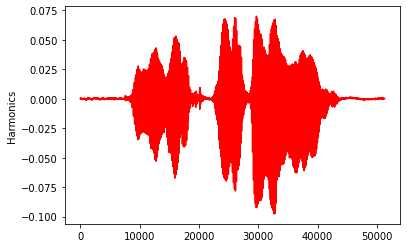

In [ ]:
# Calculating Harmonics

wav_harmonic = librosa.effects.hpss(audio_vectors)[0]
plt.plot(wav_harmonic, color='r')
plt.ylabel('Harmonics')

Text(0, 0.5, 'Autocorrelations')

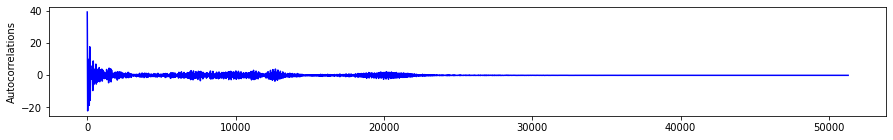

In [ ]:
# Calculating auto correlation

autocorr = librosa.core.autocorrelate(audio_vectors)
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='b')
plt.ylabel('Autocorrelations')

Text(0, 0.5, 'Center-clipped Autocorrelation')

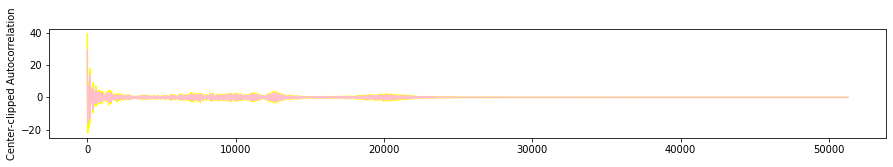

In [ ]:
# Some CL auto correlation
cl = 0.45 * np.mean(abs(audio_vectors))
center_clipped = []
for s in audio_vectors:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='yellow')
plt.plot(new_autocorr, color='pink')
plt.ylabel('Center-clipped Autocorrelation')

## Emotion: Happy

In [ ]:
audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Happy/train/0011_001042.wav'
audio_vectors , sr = librosa.load(audio_path)
print("Audio Vectors: ",audio_vectors)
print("sr: ", sr)

Audio Vectors:  [ 1.3001023e-06  4.8348254e-05  6.3254432e-05 ... -1.2531741e-04
 -1.3208053e-04  0.0000000e+00]
sr:  22050


In [ ]:
# Running audio
Audio(audio_vectors, rate=sr)

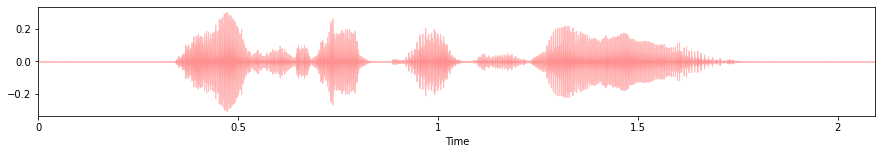

In [ ]:
# Audio file waveplot
plt.figure(figsize=(15,2))
librosa.display.waveplot(audio_vectors, sr=sr, max_sr=1000, alpha=0.25, color='r')

Text(0, 0.5, 'RMSE')

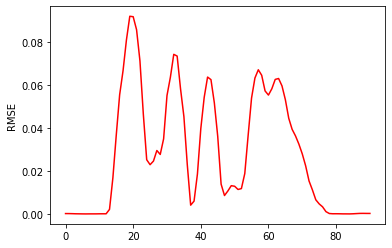

In [ ]:
# RMSE calculation and plot
rmse_val = librosa.feature.rms(audio_vectors + 0.0001)[0]
plt.plot(rmse_val, color='r')
plt.ylabel('RMSE')

In [ ]:
# Calculating silence for this particular wave file
silence = 0
for e in rmse_val:
    if e <= 0.12 * np.mean(rmse_val):
        silence += 1

print(silence/float(len(rmse_val)))

0.3076923076923077


Text(0, 0.5, 'Harmonics')

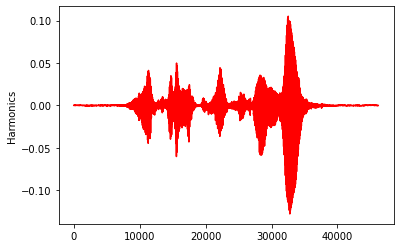

In [ ]:
# Calculating Harmonics

wav_harmonic = librosa.effects.hpss(audio_vectors)[0]
plt.plot(wav_harmonic, color='r')
plt.ylabel('Harmonics')

Text(0, 0.5, 'Autocorrelations')

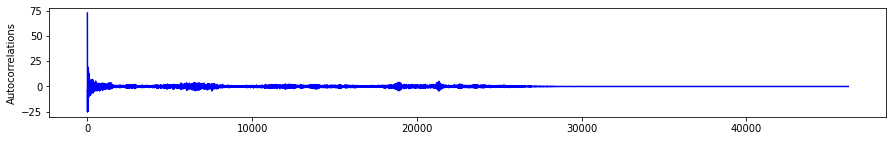

In [ ]:
# Calculating auto correlation

autocorr = librosa.core.autocorrelate(audio_vectors)
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='b')
plt.ylabel('Autocorrelations')

Text(0, 0.5, 'Center-clipped Autocorrelation')

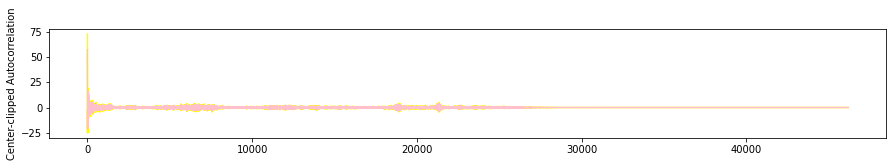

In [ ]:
# Some CL auto correlation
cl = 0.45 * np.mean(abs(audio_vectors))
center_clipped = []
for s in audio_vectors:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='yellow')
plt.plot(new_autocorr, color='pink')
plt.ylabel('Center-clipped Autocorrelation')

## Emotion: Neutral

In [ ]:
audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Neutral/train/0011_000310.wav'
audio_vectors , sr = librosa.load(audio_path)
print("Audio Vectors: ",audio_vectors)
print("sr: ", sr)

Audio Vectors:  [-0.00053685 -0.00062499 -0.00054079 ...  0.00014737  0.00017295
  0.        ]
sr:  22050


In [ ]:
# Running audio
Audio(audio_vectors, rate=sr)

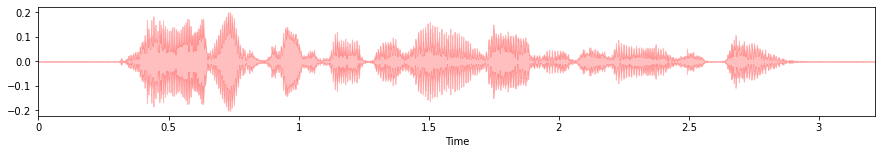

In [ ]:
# Audio file waveplot
plt.figure(figsize=(15,2))
librosa.display.waveplot(audio_vectors, sr=sr, max_sr=1000, alpha=0.25, color='r')

Text(0, 0.5, 'RMSE')

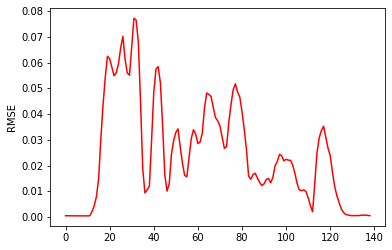

In [ ]:
# RMSE calculation and plot
rmse_val = librosa.feature.rms(audio_vectors + 0.0001)[0]
plt.plot(rmse_val, color='r')
plt.ylabel('RMSE')

In [ ]:
# Calculating silence for this particular wave file
silence = 0
for e in rmse_val:
    if e <= 0.10 * np.mean(rmse_val):
        silence += 1

print(silence/float(len(rmse_val)))

0.19424460431654678


Text(0, 0.5, 'Harmonics')

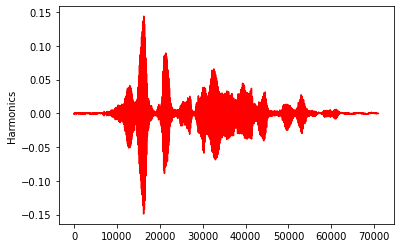

In [ ]:
# Calculating Harmonics

wav_harmonic = librosa.effects.hpss(audio_vectors)[0]
plt.plot(wav_harmonic, color='r')
plt.ylabel('Harmonics')

Text(0, 0.5, 'Autocorrelations')

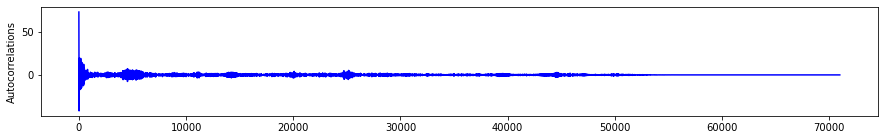

In [ ]:
# Calculating auto correlation

autocorr = librosa.core.autocorrelate(audio_vectors)
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='b')
plt.ylabel('Autocorrelations')

Text(0, 0.5, 'Center-clipped Autocorrelation')

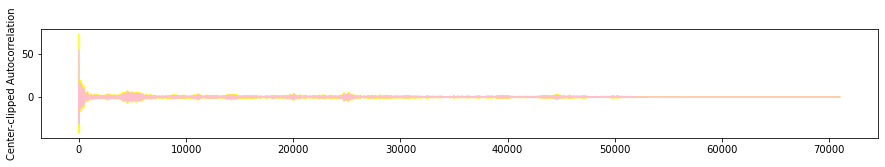

In [ ]:
# Some CL auto correlation
cl = 0.45 * np.mean(abs(audio_vectors))
center_clipped = []
for s in audio_vectors:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='yellow')
plt.plot(new_autocorr, color='pink')
plt.ylabel('Center-clipped Autocorrelation')

## Emotion: Surprise

In [ ]:
audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Surprise/train/0011_001703.wav'
audio_vectors , sr = librosa.load(audio_path)
print("Audio Vectors: ",audio_vectors)
print("sr: ", sr)

Audio Vectors:  [-0.00071607 -0.00078786 -0.00063301 ... -0.00033843 -0.0003595
  0.        ]
sr:  22050


In [ ]:
# Running audio
Audio(audio_vectors, rate=sr)

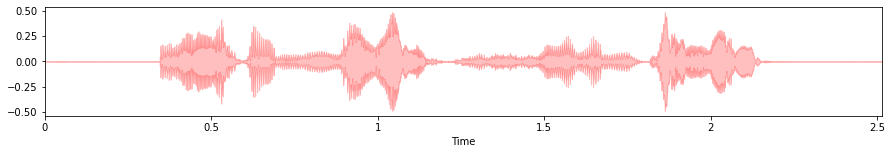

In [ ]:
# Audio file waveplot
plt.figure(figsize=(15,2))
librosa.display.waveplot(audio_vectors, sr=sr, max_sr=1000, alpha=0.25, color='r')

Text(0, 0.5, 'RMSE')

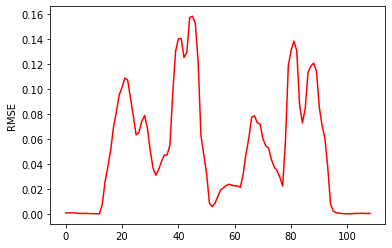

In [ ]:
# RMSE calculation and plot
rmse_val = librosa.feature.rms(audio_vectors + 0.0001)[0]
plt.plot(rmse_val, color='r')
plt.ylabel('RMSE')

In [ ]:
# Calculating silence for this particular wave file
silence = 0
for e in rmse_val:
    if e <= 0.12 * np.mean(rmse_val):
        silence += 1

print(silence/float(len(rmse_val)))

0.25688073394495414


Text(0, 0.5, 'Harmonics')

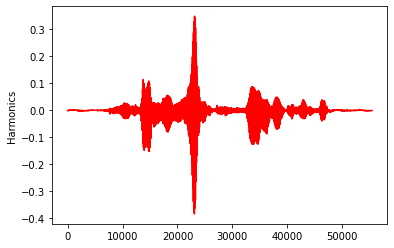

In [ ]:
# Calculating Harmonics

wav_harmonic = librosa.effects.hpss(audio_vectors)[0]
plt.plot(wav_harmonic, color='r')
plt.ylabel('Harmonics')

Text(0, 0.5, 'Autocorrelations')

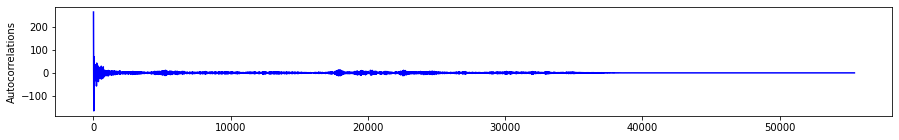

In [ ]:
# Calculating auto correlation

autocorr = librosa.core.autocorrelate(audio_vectors)
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='b')
plt.ylabel('Autocorrelations')

Text(0, 0.5, 'Center-clipped Autocorrelation')

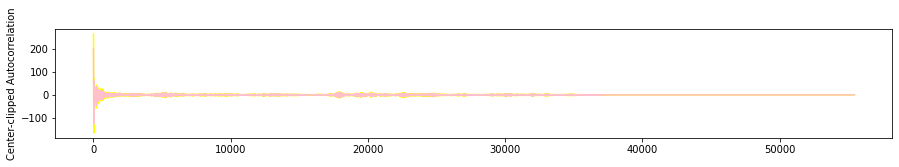

In [ ]:
# Some CL auto correlation
cl = 0.45 * np.mean(abs(audio_vectors))
center_clipped = []
for s in audio_vectors:
    if s >= cl:
        center_clipped.append(s - cl)
    elif s <= -cl:
        center_clipped.append(s + cl)
    elif np.abs(s) < cl:
        center_clipped.append(0)
new_autocorr = librosa.core.autocorrelate(np.array(center_clipped))
plt.figure(figsize=(15,2))
plt.plot(autocorr, color='yellow')
plt.plot(new_autocorr, color='pink')
plt.ylabel('Center-clipped Autocorrelation')

## Comparing emotions

In [ ]:
# Angry
angry_audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Angry/train/0011_000693.wav'
av_angry , sr = librosa.load(angry_audio_path)

# Sad
sad_audio_path = '/content/drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD/0011/Sad/train/0011_001400.wav'
av_sad , sr = librosa.load(sad_audio_path)


In [ ]:
min_len = min(len(av_angry), len(av_sad))
av_angry, av_sad = av_angry[:min_len], av_sad[:min_len]

In [ ]:
Audio(av_angry, rate=sr)

In [ ]:
Audio(av_sad, rate=sr)

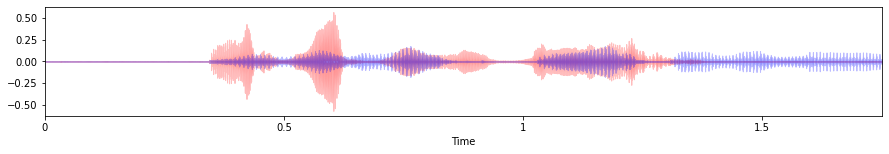

In [ ]:
plt.figure(figsize=(15,2))
librosa.display.waveplot(av_angry, sr=sr, max_sr=1000, alpha=0.25, color='r')
librosa.display.waveplot(av_sad, sr=sr, max_sr=1000, alpha=0.25, color='b')

Text(0, 0.5, 'RMSE')

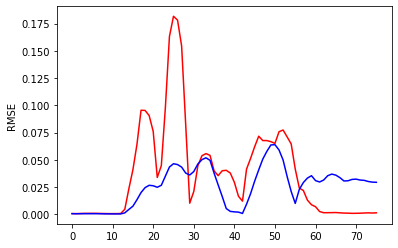

In [ ]:
# Calculating RMSE

rmse_angry = librosa.feature.rms(av_angry + 0.0001)[0]
rmse_sad = librosa.feature.rms(av_sad + 0.0001)[0]
# plt.figure(figsize=(15,2))
plt.plot(rmse_angry, color='r')
plt.plot(rmse_sad, color='b')
plt.ylabel('RMSE')

In [ ]:
# Silence

silence_angry = 0
for e in rmse_angry:
    if e <= 0.12 * np.mean(rmse_angry):
        silence_angry += 1
        
silence_sad = 0
for e in rmse_sad:
    if e <= 0.12 * np.mean(rmse_sad):
        silence_sad += 1

print("Silences for each emotion: \nAngry = ",silence_angry/float(len(rmse_angry)),"\nSad = ", silence_sad/float(len(rmse_sad)))

Silences for each emotion: 
Angry =  0.3684210526315789 
Sad =  0.23684210526315788


Text(0, 0.5, 'Harmonics')

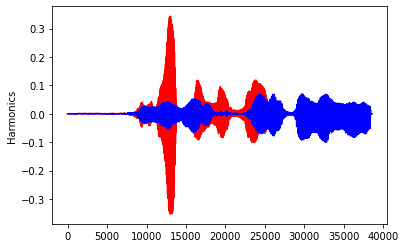

In [ ]:
# Harmonics

y1_harmonic = librosa.effects.hpss(av_angry)[0]
y2_harmonic = librosa.effects.hpss(av_sad)[0]
# plt.figure(figsize=(5,2))
plt.plot(y1_harmonic, color='r')
plt.plot(y2_harmonic, color='b')
plt.ylabel('Harmonics')

Text(0, 0.5, 'Autocorrelations')

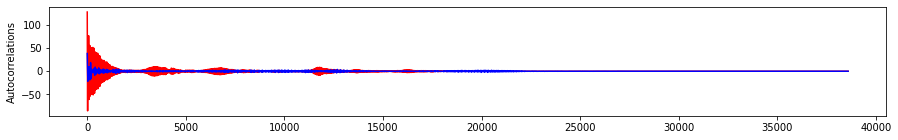

In [ ]:
# Auto correlations
autocorr1 = librosa.core.autocorrelate(av_angry)
autocorr2 = librosa.core.autocorrelate(av_sad)
plt.figure(figsize=(15,2))
plt.plot(autocorr1, color='r')
plt.plot(autocorr2, color='b')
plt.ylabel('Autocorrelations')

# Vertex AI ?


### Setup

In [ ]:
PROJECT_ID = "wav2vecemotionvoicerecognition"  # @param {type:"string"}

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [ ]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
REGION = "us-central1"  # @param {type: "string"}

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Google Cloud Notebook, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Cloud Bucket Setup

In [ ]:
BUCKET_NAME = "gs://audio_emotion_dataset"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Creating gs://audio_emotion_dataset/...
ServiceException: 409 A Cloud Storage bucket named 'audio_emotion_dataset' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [ ]:
! gsutil ls -al $BUCKET_NAME

      2134  2021-11-26T18:46:48Z  gs://audio_emotion_dataset/aiplatform-2021-11-26-18:46:48.678-aiplatform_custom_trainer_script-0.1.tar.gz#1637952408799864  metageneration=1
      1657  2021-11-27T21:06:26Z  gs://audio_emotion_dataset/aiplatform-2021-11-27-21:06:26.824-aiplatform_custom_trainer_script-0.1.tar.gz#1638047186996612  metageneration=1
      1662  2021-11-27T21:22:51Z  gs://audio_emotion_dataset/aiplatform-2021-11-27-21:22:51.266-aiplatform_custom_trainer_script-0.1.tar.gz#1638048171430347  metageneration=1
      1677  2021-11-27T21:30:17Z  gs://audio_emotion_dataset/aiplatform-2021-11-27-21:30:17.520-aiplatform_custom_trainer_script-0.1.tar.gz#1638048617724316  metageneration=1
      1666  2021-11-27T21:40:16Z  gs://audio_emotion_dataset/aiplatform-2021-11-27-21:40:16.641-aiplatform_custom_trainer_script-0.1.tar.gz#1638049216813954  metageneration=1
      1801  2021-11-27T22:04:34Z  gs://audio_emotion_dataset/aiplatform-2021-11-27-22:04:34.230-aiplatform_custom_trainer_scr

### Setup VertexAI Variables/Env

In [ ]:
import google.cloud.aiplatform as aip

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_NAME)

In [ ]:
if os.getenv("IS_TESTING_TRAIN_GPU"):
    TRAIN_GPU, TRAIN_NGPU = (
        aip.gapic.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_TRAIN_GPU")),
    )
else:
    TRAIN_GPU, TRAIN_NGPU = (None, None)

if os.getenv("IS_TESTING_DEPLOY_GPU"):
    DEPLOY_GPU, DEPLOY_NGPU = (
        aip.gapic.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_DEPLOY_GPU")),
    )
else:
    DEPLOY_GPU, DEPLOY_NGPU = (None, None)

In [ ]:
if os.getenv("IS_TESTING_TF"):
    TF = os.getenv("IS_TESTING_TF")
else:
    TF = "2-1"

if TF[0] == "2":
    if TRAIN_GPU:
        TRAIN_VERSION = "tf-gpu.{}".format(TF)
    else:
        TRAIN_VERSION = "tf-cpu.{}".format(TF)
    if DEPLOY_GPU:
        DEPLOY_VERSION = "tf2-gpu.{}".format(TF)
    else:
        DEPLOY_VERSION = "tf2-cpu.{}".format(TF)
else:
    if TRAIN_GPU:
        TRAIN_VERSION = "tf-gpu.{}".format(TF)
    else:
        TRAIN_VERSION = "tf-cpu.{}".format(TF)
    if DEPLOY_GPU:
        DEPLOY_VERSION = "tf-gpu.{}".format(TF)
    else:
        DEPLOY_VERSION = "tf-cpu.{}".format(TF)

TRAIN_IMAGE = "gcr.io/cloud-aiplatform/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "gcr.io/cloud-aiplatform/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

Training: gcr.io/cloud-aiplatform/training/tf-cpu.2-1:latest None None
Deployment: gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-1:latest None None


In [ ]:
if os.getenv("IS_TESTING_TRAIN_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_TRAIN_MACHINE")
else:
    MACHINE_TYPE = "n1-highmem"

VCPU = "8"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

if os.getenv("IS_TESTING_DEPLOY_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_DEPLOY_MACHINE")
else:
    MACHINE_TYPE = "n1-highmem"

VCPU = "8"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Train machine type n1-highmem-8
Deploy machine type n1-highmem-8


### Setting Up task.py

In [ ]:
# Make folder for Python training script
! rm -rf custom
! mkdir custom

# Add package information
! touch custom/README.md

setup_cfg = "[egg_info]\n\ntag_build =\n\ntag_date = 0"
! echo "$setup_cfg" > custom/setup.cfg

setup_py = "import setuptools\n\nsetuptools.setup(\n\n    install_requires=[\n\n        'tensorflow_datasets==1.3.0',\n\n   ],\n\n    packages=setuptools.find_packages())"
! echo "$setup_py" > custom/setup.py

pkg_info = "Metadata-Version: 1.0\n\nName: CIFAR10 image classification\n\nVersion: 0.0.0\n\nSummary: Demostration training script\n\nHome-page: www.google.com\n\nAuthor: Google\n\nAuthor-email: aferlitsch@google.com\n\nLicense: Public\n\nDescription: Demo\n\nPlatform: Vertex"
! echo "$pkg_info" > custom/PKG-INFO

# Make the training subfolder
! mkdir custom/trainer
! touch custom/trainer/__init__.py

In [ ]:
%%writefile custom/trainer/task.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
import torchaudio

import gcsfs
fs = gcsfs.GCSFileSystem(project='wav2vecemotionvoicerecognition', token='cloud')

tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--model-dir', dest='model_dir',
                    default=os.getenv("AIP_MODEL_DIR"), type=str, help='Model dir.')
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

def load_csv():
  # Loading the created dataset using datasets
  from datasets import load_dataset, load_metric

  train_file = "audio_emotion_dataset/Dataset/train.csv"
  test_file = "audio_emotion_dataset/Dataset/test.csv"

  data_files = {
      "train": train_file, 
      "validation": test_file,
  }
  
  from datasets import Dataset
  import pandas as pd
  with fs.open(train_file, 'rb') as f:

    df = pd.read_csv(f, sep='\t') 
    train_dataset = Dataset.from_pandas(df)

  with fs.open(test_file, 'rb') as f:

    df = pd.read_csv(f, sep='\t') 
    eval_dataset = Dataset.from_pandas(df)

  return train_dataset, eval_dataset


train_dataset, eval_dataset = load_csv()

# We need to specify the input and output column
input_column = "path"
output_column = "emotion"

# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
# print(f"A classification problem with {num_labels} classes: {label_list}")

from transformers import AutoConfig, Wav2Vec2Processor

model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
pooling_mode = "mean"

processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

import gcsfs
fs = gcsfs.GCSFileSystem(project='wav2vecemotionvoicerecognition', token='cloud')
fs.get("audio_emotion_dataset", './audio_emotion_dataset', recursive=True)

def speech_file_to_array_fn(path):
    # import soundfile as sf
    # import io

    # speech_array, sampling_rate = sf.read(file=io.BytesIO(f), dtype='float32')
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
is_regression = False

import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

model.freeze_feature_extractor()

from transformers import TrainingArguments

training_args = TrainingArguments(
    # output_dir=args.model_dir,
    output_dir="./",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=1.0,
    save_steps=1,
    eval_steps=1,
    logging_steps=1,
    learning_rate=1e-4,
    save_total_limit=2,
)

from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()

trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

# trainer.train()
trainer.save_model("./Models")
processor.save_pretrained('./Models')
fs.put('./Models', "audio_emotion_dataset/Models", recursive=True)


Writing custom/trainer/task.py


In [ ]:
! rm -f custom.tar custom.tar.gz
! tar cvf custom.tar custom
! gzip custom.tar
! gsutil cp custom.tar.gz $BUCKET_NAME/trainer_cifar10.tar.gz

custom/
custom/setup.py
custom/setup.cfg
custom/PKG-INFO
custom/trainer/
custom/trainer/__init__.py
custom/trainer/task.py
custom/README.md
Copying file://custom.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  5.3 KiB/  5.3 KiB]                                                
Operation completed over 1 objects/5.3 KiB.                                      


### Create and Run

In [ ]:
job = aip.CustomTrainingJob(
    display_name="cifar10_" + TIMESTAMP,
    script_path="custom/trainer/task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["gcsfs==0.7.1", "tensorflow-datasets==4.4", "datasets", "transformers", "SoundFile", "tensorflow==2.7.0", "torch==1.10.0", "torchvision==0.11.1", "torchaudio==0.10.0"],
)

print(job)

In [ ]:
# MODEL_DIR = "{}/{}".format(BUCKET_NAME, TIMESTAMP)
MODEL_DIR = "{}/{}".format(BUCKET_NAME, "Models")
EPOCHS = 20
STEPS = 100

DIRECT = True
if DIRECT:
    CMDARGS = [
        "--model-dir=" + MODEL_DIR,
        "--epochs=" + str(EPOCHS),
        "--steps=" + str(STEPS),
    ]
else:
    CMDARGS = [
        "--epochs=" + str(EPOCHS),
        "--steps=" + str(STEPS),
    ]

In [ ]:
if TRAIN_GPU:
    job.run(
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
        base_output_dir=MODEL_DIR,
        sync=True,
    )
else:
    job.run(
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        base_output_dir=MODEL_DIR,
        sync=True,
    )

model_path_to_deploy = MODEL_DIR

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://audio_emotion_dataset/aiplatform-2021-12-09-05:36:30.161-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://audio_emotion_dataset/Models 
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2238941025198407680?project=35996520627
INFO:google.cloud.aiplatform.training_jobs:View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5711568181621948416?project=35996520627
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/35996520627/locations/us-central1/trainingPipelines/2238941025198407680 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/35996520627/locations/us-central1/trainingPipelines/2238941025198407680 current state:
Pipe

# Colab Training 

## Import the modules

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split

## Read dataset from google drive and generte csv file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_dataset():
  path_to_data = "drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD_small/"
  df = pd.DataFrame(columns = ['name', 'path', 'emotion'])

  for subdir, dirs, files in os.walk(path_to_data):
    for name in files:
      if name.endswith('.txt'):
        continue
      path = os.path.join(subdir,name)
     
      parent_dir = os.path.dirname(path)
      parent_dir = os.path.dirname(parent_dir)
      emotion = os.path.basename(parent_dir)
      name = os.path.basename(path)
      df.loc[len(df.index)] = [name, path, emotion] 
  return df

In [ ]:
df = load_dataset()
df.head()

name                                               path emotion
0  0001_000371.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...   Angry
1  0001_000372.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...   Angry
2  0001_000375.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...   Angry
3  0001_000373.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...   Angry
4  0001_000374.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...   Angry

In [ ]:
print("Labels: ", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

Labels:  ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprise']



path
emotion       
Angry       30
Happy       30
Neutral     30
Sad        202
Surprise   213

In [ ]:
df.to_csv("drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/esd.csv")

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])
save_path = "drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset"
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

In [ ]:
train_df.head(20)

name  ...   emotion
0   0001_001657.wav  ...  Surprise
1   0001_001451.wav  ...  Surprise
2   0001_001583.wav  ...  Surprise
3   0001_001586.wav  ...  Surprise
4   0001_001176.wav  ...       Sad
5   0001_000034.wav  ...   Neutral
6   0001_001171.wav  ...       Sad
7   0001_001483.wav  ...  Surprise
8   0001_001256.wav  ...       Sad
9   0001_001153.wav  ...       Sad
10  0001_001469.wav  ...  Surprise
11  0001_000390.wav  ...     Angry
12  0001_001497.wav  ...  Surprise
13  0001_001187.wav  ...       Sad
14  0001_001467.wav  ...  Surprise
15  0001_001511.wav  ...  Surprise
16  0001_001607.wav  ...  Surprise
17  0001_000742.wav  ...     Happy
18  0001_001302.wav  ...       Sad
19  0001_000024.wav  ...   Neutral

[20 rows x 3 columns]

## Prepare Data for Training

In [ ]:
from datasets import load_dataset, load_metric

train_file = "/content/data/train.csv"
test_file = "/content/data/test.csv"

train_file = "drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/train.csv"
test_file = "drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/test.csv"

data_files = {
    "train": train_file, 
    "validation": test_file,
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

print(train_dataset)
print(eval_dataset)

Using custom data configuration default-c7d31b092148fec8


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-c7d31b092148fec8/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 404
})
Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 101
})


In [ ]:
input_column = "path"
output_column = "emotion"

In [ ]:
label_list = train_dataset.unique(output_column)
label_list.sort()  
num_labels = len(label_list)
print(f"speech classification problem with {num_labels} classes: {label_list}")

speech classification problem with 5 classes: ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


We are using the pre-trained model `lighteternal/wav2vec2-large-xlsr-53-greek` fine-tuned by [Dimitris Papadopoulos](https://huggingface.co/lighteternal/wav2vec2-large-xlsr-53-greek)

In [ ]:
from transformers import AutoConfig, Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC

model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
pooling_mode = "mean"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/535 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:349: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


The target sampling rate: 16000


Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['quantizer.codevectors', 'project_hid.bias', 'project_q.bias', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_q.weight', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [ ]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:349: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


## Preprocess the data

In [ ]:
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):

    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

In [ ]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['emotion']}")

Training input_values: [-0.003898897208273411, -0.003898897208273411, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0020856305491179228, -0.0020856305491179228, -0.0020856305491179228, -0.0020856305491179228, -0.0020856305491179228, -0.0029922639951109886, -0.0020856305491179228, -0.0020856305491179228, -0.0020856305491179228, -0.0020856305491179228, -0.0011789973359555006, -0.0029922639951109886, -0.0020856305491179228, -0.0029922639951109886, -0.0029922639951109886, -0.0020856305491179228, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.0029922639951109886, -0.003898897208273411, -0.003898897208273411, -0.003898897208273411, -0.0029922639951109886, -0.004805530421435833, -0.003898897208273411, -0.003898897208273411, -0.003898897208273411, -

## Model Definition

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None

In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

## Setup the training

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
is_regression = False

In [ ]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at lighteternal/wav2vec2-large-xlsr-53-greek were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at lighteternal/wav2vec2-large-xlsr-53-greek and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a d

In [ ]:
model.freeze_feature_extractor()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/wav2vec2-xlsr-greek-speech-emotion-recognition",
    # output_dir="/content/gdrive/MyDrive/wav2vec2-xlsr-greek-speech-emotion-recognition"
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=1.0,
    fp16=True,
    save_steps=1,
    eval_steps=1,
    logging_steps=1,
    learning_rate=1e-4,
    save_total_limit=2,
)

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()

In [ ]:
trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


## Training

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: name, emotion, path.
***** Running training *****
  Num examples = 404
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 50
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: anirudh44 (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


Saving model checkpoint to /content/wav2vec2-xlsr-greek-speech-emotion-recognition/checkpoint-1
Configuration saved in /content/wav2vec2-xlsr-greek-speech-emotion-recognition/checkpoint-1/config.json
Model weights saved in /content/wav2vec2-xlsr-greek-speech-emotion-recognition/checkpoint-1/pytorch_model.bin
Configuration saved in /content/wav2vec2-xlsr-greek-speech-emotion-recognition/checkpoint-1/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1
Saving model checkpoint to /content/wav2vec2-xlsr-

TrainOutput(global_step=50, training_loss=0.8863648223876953, metrics={'train_runtime': 4158.3926, 'train_samples_per_second': 0.097, 'train_steps_per_second': 0.012, 'total_flos': 6.31603433853216e+16, 'train_loss': 0.8863648223876953, 'epoch': 0.99})

## Model Saving

In [ ]:
trainer.save_model("drive/Shareddrives/cmpe-297_Special_Topics_Project/Models")
processor.save_pretrained('drive/Shareddrives/cmpe-297_Special_Topics_Project/Models')

Saving model checkpoint to drive/Shareddrives/cmpe-297_Special_Topics_Project/Models
Configuration saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/config.json
Model weights saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/pytorch_model.bin
Configuration saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/preprocessor_config.json
Configuration saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/preprocessor_config.json
tokenizer config file saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/tokenizer_config.json
Special tokens file saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/special_tokens_map.json
added tokens file saved in drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/added_tokens.json


## Model Evaluation

In [ ]:
import librosa
from sklearn.metrics import classification_report

In [ ]:
test_dataset = load_dataset("csv", data_files={"test": "drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/test.csv"}, delimiter="\t")["test"]
test_dataset

Using custom data configuration default-2064331aeb3d411b


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /content/cache/csv/default-2064331aeb3d411b/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 101
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
model_name_or_path = "drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

loading configuration file drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSpeechClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_

In [ ]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    speech_array = speech_array.squeeze().numpy()
    speech_array = librosa.resample(np.asarray(speech_array), sampling_rate, processor.feature_extractor.sampling_rate)

    batch["speech"] = speech_array
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch

In [ ]:
test_dataset = test_dataset.map(speech_file_to_array_fn)

  0%|          | 0/101 [00:00<?, ?ex/s]

In [ ]:
result = test_dataset.map(predict, batched=True, batch_size=8)

  0%|          | 0/13 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [ ]:
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names

['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_pred[:5])

[4, 4, 4, 4, 3]


In [ ]:
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         6
       Happy       0.00      0.00      0.00         6
     Neutral       0.00      0.00      0.00         6
         Sad       0.98      1.00      0.99        40
    Surprise       0.72      1.00      0.83        43

    accuracy                           0.82       101
   macro avg       0.34      0.40      0.36       101
weighted avg       0.69      0.82      0.75       101



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name_or_path = "drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
sampling_rate = processor.feature_extractor.sampling_rate
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)

loading configuration file drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "drive/Shareddrives/cmpe-297_Special_Topics_Project/Models/",
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForSpeechClassification"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 256,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": true,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_

In [ ]:
def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    try:

      speech = speech_file_to_array_fn(path, sampling_rate)
      features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

      input_values = features.input_values.to(device)
      attention_mask = features.attention_mask.to(device)

      with torch.no_grad():
          logits = model(input_values, attention_mask=attention_mask).logits

      scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
      outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
      return outputs
    except Exception as e:
      return e


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    print(path)
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    speech = librosa.resample(np.asarray(speech), sr, sampling_rate)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sampling_rate))

    outputs = predict(path, sampling_rate)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [ ]:
outputs = predict("drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD_small/Surprise/train/0001_001605.wav", sampling_rate)

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [ ]:
outputs

[{'Emotion': 'Angry', 'Score': '3.6%'},
 {'Emotion': 'Happy', 'Score': '2.8%'},
 {'Emotion': 'Neutral', 'Score': '3.3%'},
 {'Emotion': 'Sad', 'Score': '1.6%'},
 {'Emotion': 'Surprise', 'Score': '88.8%'}]

In [ ]:
test = pd.read_csv("drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/test.csv", sep="\t")
#test = pd.read_csv("/content/data/test.csv", sep="\t")
test.head()

name                                               path   emotion
0  0001_001577.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...  Surprise
1  0001_001605.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...  Surprise
2  0001_001618.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...  Surprise
3  0001_000735.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...     Happy
4  0001_001189.wav  drive/Shareddrives/cmpe-297_Special_Topics_Pro...       Sad

In [ ]:
prediction(test.iloc[0])

drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD_small/Surprise/train/0001_001577.wav


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [ ]:
prediction(test.iloc[1])

drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD_small/Surprise/train/0001_001605.wav


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [ ]:
prediction(test.iloc[2])

drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD_small/Surprise/train/0001_001618.wav


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [ ]:
prediction(test.iloc[11])

drive/Shareddrives/cmpe-297_Special_Topics_Project/Dataset/ESD_small/Surprise/train/0001_001631.wav


/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


# Gradio App Integration

In [ ]:
!pip install gradio -q
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 5.3 MB/s 
     |████████████████████████████████| 61 kB 413 kB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 3.3 MB 37.0 MB/s 


In [ ]:
import gradio as gr
import librosa
import soundfile as sf
import torch
# import warnings

# from transformers import AutoTokenizer, Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Tokenizer
from transformers import Wav2Vec2ForMaskedLM, Wav2Vec2Tokenizer
from transformers import AutoConfig, Wav2Vec2Processor

In [ ]:
# load wav2vec2 tokenizer and model 
# tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")

#define speech to text function
def asr_transcribe(audio_file):
  outputs = predict(audio_file.name, sampling_rate)
  maxScore = None
  maxEmotion = None

  for item in outputs:
      tmpScore = item['Score']
      tmpScore = float(tmpScore.split("%")[0])

      if maxScore == None:
          maxScore = float(item['Score'].split("%")[0])
          maxEmotion = item['Emotion']

      if maxScore < tmpScore:
          maxScore = tmpScore
          maxEmotion = item['Emotion']
  return maxEmotion

In [ ]:
gradio_asr = gr.Interface(
    fn=asr_transcribe,
    title="Emotion Voice Recognition with Wav2Vec2 Hugging Face",
    description="Upload an audio clip, and let Transcribe the word",
    inputs=gr.inputs.Audio(label="Upload Audio File", type="file"),
    outputs=gr.outputs.Textbox(label="Emotion Recognized"),
)

In [ ]:
gradio_asr.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://20196.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7873/',
 'https://20196.gradio.app')